In [1]:
import torch
from torch import Tensor
from math import ceil
from torch.autograd import Function

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cpu


In [2]:
import triton
import triton.language as tl

In [4]:
from torch import nn, Tensor
import torch
from torch.autograd.function import Function
import triton
import triton.language as tl

torch_ref_module = nn.Softmax


import torch
from torch import Tensor
import os


def validate_contiguous(x: Tensor) -> Tensor:
    return x if x.is_contiguous() else x.contiguous()


def validate_tensor_device(x: Tensor):
    if not x.is_cuda:
        message = "Tensor must be on CUDA or TRITON_INTERPRET must be set to '1'"
        assert os.environ.get("TRITON_INTERPRET", False) == "1", message


def is_cuda_available() -> bool:
    return torch.cuda.is_available()


def get_device() -> torch.device:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return torch.device(device)




@triton.jit
def _softmax_triton_fwd(
    x_pointer, y_pointer, x_stride, y_stride, n_rows, n_cols, block_size: tl.constexpr
):
    # get the program id: each program of the grid handles one (or more) rows of the tensor
    pid = tl.program_id(axis=0)

    # strided execution: can run the program in a strided way (e.g. for row 0, 8, 16, ...)
    row_step = tl.num_programs(axis=0)  # n. of programs running on given axis

    col_offset = tl.arange(0, block_size)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = col_offset < n_cols

    # loop through the rows executed by program with this pid
    for row_idx in tl.range(pid, n_rows, row_step):
        x_row_pointer = x_pointer + row_idx * x_stride
        x_col_pointer = x_row_pointer + col_offset

        # compute the softmax (with shift for numerical stab.)
        row = tl.load(x_col_pointer, mask, other=-float("inf"))

        row_minus_max = row - tl.max(row, axis=0)
        num = tl.exp(row_minus_max)
        den = tl.sum(num, axis=0)
        y = num / den

        y_row_pointer = y_pointer + row_idx * y_stride
        y_col_pointer = y_row_pointer + col_offset
        tl.store(y_col_pointer, y, mask)


def _softmax_fwd(x: Tensor, block_size: int = 1024) -> Tensor:
    validate_tensor_device(x)

    n_rows, n_cols = x.shape
    y = torch.empty_like(x)
    grid = (n_rows,)
    block_size = triton.next_power_of_2(n_cols)  # Used to tile the row

    _softmax_triton_fwd[grid](
        x, y, x.stride(0), y.stride(0), n_rows, n_cols, block_size
    )
    return y


@triton.jit
def load_tensor_row(x_ptr, row_idx, x_stride, col_ptr_offset, mask, other):
    # row pointer
    row_ptr = x_ptr + row_idx * x_stride

    # col pointer
    col_ptr = row_ptr + col_ptr_offset

    # load all tensors
    return tl.load(col_ptr, mask, other=other)


@triton.jit
def _softmax_triton_bwd(
    s_ptr,
    grad_output_ptr,
    grad_input_ptr,
    s_stride,
    grad_output_stride,
    grad_input_stride,
    nrows,
    ncols,
    block_size: tl.constexpr,
):

    pid = tl.program_id(axis=0)
    row_step = tl.num_programs(axis=0)
    col_ptr_offset = tl.arange(0, block_size)
    mask = col_ptr_offset < ncols

    for row_idx in tl.range(pid, nrows, row_step):
        ### load s
        s = tl.load(s_ptr + row_idx * s_stride + col_ptr_offset, mask)

        ### load grad_output
        grad_output = tl.load(
            grad_output_ptr + row_idx * grad_output_stride + col_ptr_offset,
            mask,
        )

        # perform coputations
        # grad_input = s * grad_output
        alpha = tl.sum(s * grad_output, axis=0)
        grad_input = s * (grad_output - alpha)

        # store the results
        tl.store(
            grad_input_ptr + row_idx * grad_input_stride + col_ptr_offset,
            grad_input,
            mask,
        )


def _softmax_bwd(s: Tensor, grad_output: Tensor, block_size: int = 1024) -> Tensor:
    for x in (s, grad_output):
        validate_tensor_device(x)

    nrows, ncols = s.shape
    grad_input = torch.empty_like(grad_output).to(s.device)
    grid = (nrows,)

    block_size = triton.next_power_of_2(ncols)

    _softmax_triton_bwd[grid](
        s,
        grad_output,
        grad_input,
        s.stride(0),
        grad_output.stride(0),
        grad_input.stride(0),
        nrows,
        ncols,
        block_size,
    )

    return grad_input


class SoftmaxFunction(Function):
    def forward(ctx, x):
        s = _softmax_fwd(x)
        ctx.save_for_backward(s)
        return s

    def backward(ctx, grad_output):
        (s,) = ctx.saved_tensors

        # exp = torch.exp(x)
        # den = exp.sum(dim=1)
        # derivative = (exp * (den - exp)) / den ** 2

        # y = torch.softmax(x, dim=1)
        # alpha = (s * grad_output).sum(dim=1, keepdim=True)
        # grad_input = s * (grad_output - alpha)

        grad_input = _softmax_bwd(s, grad_output)

        # derivative = _softmax_bwd(x)
        return grad_input


class Softmax(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        if x.ndim == 1:
            return SoftmaxFunction.apply(x[None, :]).squeeze()
        if x.ndim > 2:
            x = validate_contiguous(x)
            return SoftmaxFunction.apply(x.view(-1, x.shape[-1])).view(x.shape)
        return SoftmaxFunction.apply(x)


In [8]:
import psutil
from time import time
from typing import Optional

class Profiler:
    peak_alloc : Optional[float] = None
    
    def __init__(self, device=None):
        self.device = torch.device(device or "cuda")

    def __enter__(self):
        self.t_start = time()
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
            torch.cuda.reset_peak_memory_stats(self.device)
            self.start_alloc = torch.cuda.memory_allocated(self.device)
            self.start_reserved = torch.cuda.memory_reserved(self.device)
            self.start_rss = (
                psutil.Process(os.getpid()).memory_info().rss if psutil else None
            )
        return self

    def __exit__(self, exc_type, exc, tb):
        self.t_elapsed = time() - self.t_start
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
            self.end_alloc = torch.cuda.memory_allocated(self.device)
            self.end_reserved = torch.cuda.memory_reserved(self.device)
            self.peak_alloc = torch.cuda.max_memory_allocated(self.device)
            self.peak_reserved = torch.cuda.max_memory_reserved(self.device)

    # def report(self, unit=1024**2):
    #     to_mb = lambda b: None if b is None else b / unit
    #     return {
    #         "alloc_delta_MB": to_mb(self.end_alloc - self.start_alloc),
    #         "reserved_delta_MB": to_mb(self.end_reserved - self.start_reserved),
    #         "peak_alloc_MB": to_mb(self.peak_alloc),
    #         "peak_reserved_MB": to_mb(self.peak_reserved),
    #         "cpu_rss_MB": to_mb(self.start_rss) if self.start_rss is not None else None,
    #     }

In [17]:
Ns=[128 * i for i in range(2, 10, 1)]
M = 4096

summary = {
    "time": [], "memory": []
}

def fwd(x, provider):
    if provider == "torch":
        return torch.softmax(x, axis=-1)
    elif provider == 'triton':
        return nn.Softmax()(x)
    else:
        raise ValueError

def bwd(x, provider):
    x.requires_grad = True
    out = fwd(x, provider)
    loss = out.sum()
    loss.backward()

for N in Ns:
    with Profiler() as p:
        x = torch.rand(N,M)
        bwd(x, "torch")
    summary['time'].append(p.t_elapsed)
    summary['memory'].append(p.peak_alloc)
    

In [18]:
summary['time']

[0.12567687034606934,
 0.014774799346923828,
 0.02081155776977539,
 0.0163729190826416,
 0.03372597694396973,
 0.033648014068603516,
 0.03420233726501465,
 0.041645050048828125]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules

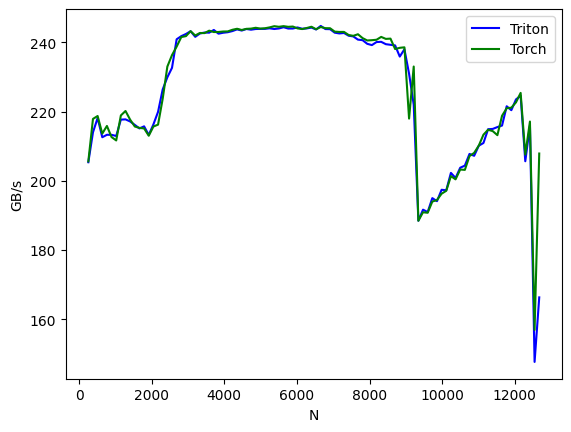

softmax-performance:
          N      Triton       Torch
0     256.0  205.363500  205.605082
1     384.0  213.995820  217.874695
2     512.0  218.135780  218.708717
3     640.0  212.578278  213.621046
4     768.0  213.284525  215.840647
5     896.0  213.278332  212.626166
6    1024.0  212.942401  211.656875
7    1152.0  217.670794  218.872704
8    1280.0  217.735394  220.162567
9    1408.0  217.130632  217.647433
10   1536.0  216.145117  215.675429
11   1664.0  215.129053  215.277044
12   1792.0  215.728841  215.124754
13   1920.0  213.243461  213.016105
14   2048.0  216.280587  215.666323
15   2176.0  219.905738  216.220259
16   2304.0  226.382347  223.700843
17   2432.0  229.890411  232.977253
18   2560.0  232.613693  236.290266
19   2688.0  240.860087  238.743363
20   2816.0  241.768494  241.505887
21   2944.0  242.383489  241.772379
22   3072.0  243.190577  243.201022
23   3200.0  241.566803  241.954119
24   3328.0  242.528388  242.678811
25   3456.0  242.810558  242.643258
26   35

In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100, 5)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=["Triton", "Torch"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))

# def fwd(x, provider):
#     if provider == "torch":
#         return torch.softmax(x, axis=-1)
#     elif provider == 'triton':
#         return nn.Softmax()(x)
#     else:
#         raise ValueError

# def bwd(x, provider):
#     out = fwd(x, provider)

#     loss = out.sum()
#     loss.backward


def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: nn.Softmax()(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

In [ ]:
@triton.jit
def fused_softmax_kernel(x_pointer, y_pointer, x_stride, y_stride, n_rows, n_cols, block_size: tl.constexpr):
    # get the program id: each program of the grid handles one (or more) rows of the tensor
    pid = tl.program_id(axis=0)

    # strided execution: can run the program in a strided way (e.g. for row 0, 8, 16, ...)
    row_step = tl.num_programs(axis=0) # n. of programs running on given axis

    # loop through the rows executed by program with this pid
    for row_idx in tl.range(pid, n_rows, row_step):
        x_row_pointer = x_pointer + row_idx * x_stride

        col_offset = tl.arange(0, block_size)
        x_col_pointer = x_row_pointer + col_offset

        # Create a mask to guard memory operations against out-of-bounds accesses.
        mask = col_offset < n_cols

        # compute the softmax (with shift for numerical stab.)
        row = tl.load(x_col_pointer, mask, other=-float('inf'))

        row_minus_max = row - tl.max(row, axis=0)
        num = tl.exp(row_minus_max)
        den = tl.sum(num, axis=0)
        y = num / den

        y_row_pointer = y_pointer + row_idx * y_stride
        y_col_pointer = y_row_pointer + col_offset
        tl.store(y_col_pointer, y, mask)


def fused_softmax_triton(x:Tensor, block_size:int=1024) -> Tensor:
    assert x.is_cuda

    n_rows, n_cols = x.shape
    y = torch.empty_like(x)
    grid = n_rows,
    BLOCK_SIZE = triton.next_power_of_2(n_cols)  # Used to tile the row

    fused_softmax_kernel[grid](x, y, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE)

    return y




In [ ]:
x = torch.rand(8, 16).to(DEVICE)
assert torch.allclose(naive_softmax(x), fused_softmax_triton(x))



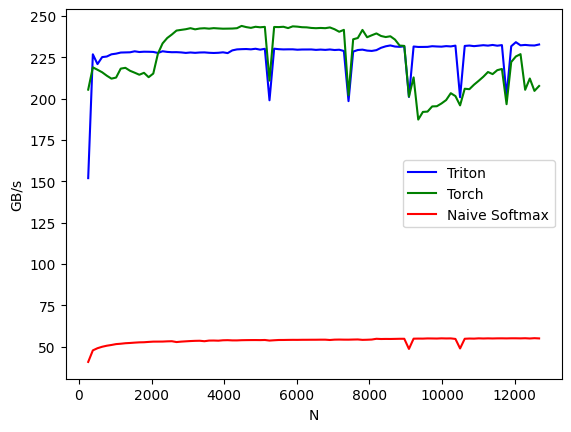

softmax-performance:
          N      Triton       Torch  Naive Softmax
0     256.0  151.980123  205.490514      40.853169
1     384.0  226.857512  218.978525      47.838907
2     512.0  220.938893  217.514575      49.142157
3     640.0  225.161262  215.992813      50.020996
4     768.0  225.520422  213.928680      50.652093
5     896.0  226.857004  212.147934      51.098348
6    1024.0  227.260291  212.789449      51.628142
7    1152.0  227.920769  218.205495      51.850982
8    1280.0  228.001137  218.683343      52.156157
9    1408.0  228.074304  216.898847      52.310863
10   1536.0  228.673505  215.738704      52.518491
11   1664.0  228.243074  214.505242      52.688767
12   1792.0  228.429241  215.666179      52.751406
13   1920.0  228.390875  213.019784      52.955124
14   2048.0  228.298355  215.220412      53.123225
15   2176.0  227.672494  227.257940      53.139178
16   2304.0  228.697633  233.448524      53.161717
17   2432.0  228.307958  236.712890      53.294922
18   2560.

In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive Softmax"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: fused_softmax_triton(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)